<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Statistical Learning and Data Mining</h1>
<h2 align="center" style="margin-top:20px">Tutorial 7: Model Selection </h2>
<br>


The tutorial on linear regression and k-Nearest Neighbours left us with two important questions: how many neighbours should we use in the kNN method? What should be our final model? In this lesson we use cross-validation to address these questions. 

<a href="#1.-Credit-card-data">Credit card data</a> <br>
<a href="#2.-Cross-validation">Cross-validation</a> <br>
<a href="#3.-Hyperparameter-optimisation">Hyperparameter optimisation</a> <br>
<a href="#4.-Feature-selection">Feature selection</a> <br>
<a href="#5.-Model-stacking">Model stacking</a> <br>
<a href="#6.-Evaluation">Evaluation</a> <br>
<a href="#7.-Further tasks">Further tasks</a> <br>

This notebook relies on the following imports and settings. We will load new functions and libraries in context to make clear what we are using them for. 

In [105]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 
# this is to clear the warnings from this page, usually we should leave this on

In [106]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [107]:
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

In [108]:
# Learning algorithms
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

# Metrics
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

# Scaler
from sklearn.preprocessing import StandardScaler

## 1. Credit Card Data

We again use the `Credit` dataset. Here we simply repeat the steps from the previous notebook to load and process the data. 

In [109]:
train=pd.read_hdf('Data/Credit.h5', 'train')
test=pd.read_hdf('Data/Credit.h5', 'test')
train.head(5) 

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance,Male,Caucasian,Asian
Obs,,,,,,,,,,,,,,
400,18.701,5524,415,5,64,7,Female,0,0,Asian,966,0,0,1
26,14.090,4323,326,5,25,16,Female,0,1,African American,671,0,0,0
280,54.319,3063,248,3,59,8,Female,1,0,Caucasian,269,0,1,0
261,67.937,5184,383,4,63,12,Male,0,1,Asian,345,1,0,1
131,23.793,3821,281,4,56,12,Female,1,1,African American,868,0,0,0


In [111]:
keep_columns = ['Income', 'Limit', 'Cards', 'Age', 'Education', 'Student', 
                                                        'Married', 'Balance', 'Male', 'Caucasian', 'Asian']
train = train.drop(columns = [c for c in train.columns if c not in keep_columns])
train.head()

,Income,Limit,Cards,Age,Education,Student,Married,Balance,Male,Caucasian,Asian
Obs,,,,,,,,,,,
400,18.701,5524,5,64,7,0,0,966,0,0,1
26,14.090,4323,5,25,16,0,1,671,0,0,0
280,54.319,3063,3,59,8,1,0,269,0,1,0
261,67.937,5184,4,63,12,0,1,345,1,0,1
131,23.793,3821,4,56,12,1,1,868,0,0,0


We'll initially consider two predictors for illustrative purposes, the credit card limit and income. 

In [112]:
# Response label
response = 'Balance'

# Response vectors 
y_train = train[response]
y_test = test[response]

## 2. Cross-validation

As our first illustration, let's consider the choice of the number of neighbours in the kNN method. We use [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html) to estimate the generalisation performance of the learning algorithm for different values of the hyperparameter.

For purposes of this section, we'll focus on only two predictors.

In [113]:
predictors = ['Limit', 'Income'] 
X_train = train[predictors] 

### Aside - What is K-Fold Cross-Validation
In K-Fold cross-validation, in this case 5-fold CV, we split the data up into 5 parts

In [9]:
np.linspace(0, len(X_train), 6)

array([  0.,  56., 112., 168., 224., 280.])

In [10]:
X_fold = {}
Y_fold = {}

for i in range(5):
    start, end = i*56, (i+1)*56
    print(f'Fold {i}: {start} - {end}')
    X_fold[i] = X_train.iloc[start : end]
    Y_fold[i] = y_train.iloc[start : end]

Fold 0: 0 - 56
Fold 1: 56 - 112
Fold 2: 112 - 168
Fold 3: 168 - 224
Fold 4: 224 - 280


Importantly, notice how we only `fold` the training data, and don't touch the testing data.

Then we will hold `Fold 0` for testing, and use `Fold 1, 2, 3, 4` for training.

In [114]:
X_fold_CV  = X_fold[0]
Y_fold_CV  = Y_fold[0]

X_fold_train = pd.concat([X_fold[1], X_fold[2], X_fold[3], X_fold[4]])
Y_fold_train = pd.concat([Y_fold[1], Y_fold[2], Y_fold[3], Y_fold[4]])

model0 = LinearRegression().fit(X_fold_train, Y_fold_train)
r_score = model0.score(X_fold_CV, Y_fold_CV)

print(f'Fold 0 - R2 Score: {round(r_score, 3)}')

Fold 0 - R2 Score: 0.879


Now we hold `Fold 1` for testing, and use `Fold 2, 3, 4, 0` for training, and repeat

In [115]:
X_fold_CV  = X_fold[1]
Y_fold_CV  = Y_fold[1]

X_fold_train = pd.concat([X_fold[2], X_fold[3], X_fold[4], X_fold[0]])
Y_fold_train = pd.concat([Y_fold[2], Y_fold[3], Y_fold[4], Y_fold[0]])

model0 = LinearRegression().fit(X_fold_train, Y_fold_train)
r_score = model0.score(X_fold_CV, Y_fold_CV)

print(f'Fold 1 - R2 Score: {round(r_score, 3)}')

Fold 1 - R2 Score: 0.893


And Repeat!

Don't worry about understanding this code, its a bit more involved but it should be simple enough to understand if you try to understand it by yourself.

In [116]:
r_scores = {}
for k in range(5):
    X_fold_CV = X_fold[k]
    Y_fold_CV = Y_fold[k]
    
    X_fold_train = pd.concat([X_fold[i] for i in range(5) if i != k])
    Y_fold_train = pd.concat([Y_fold[i] for i in range(5) if i != k])
    
    model = LinearRegression().fit(X_fold_train, Y_fold_train)
    r_scores[k] = model.score(X_fold_CV, Y_fold_CV)
    
    print(f'Fold {k} - R2 Score: {round(r_scores[k], 3)}')
    
print('-------------------')

average_r2 = np.mean([r_scores[k] for k in range(5)])
print(f'5 Fold CV Score - {round(average_r2, 3)}')

Fold 0 - R2 Score: 0.879
Fold 1 - R2 Score: 0.893
Fold 2 - R2 Score: 0.901
Fold 3 - R2 Score: 0.812
Fold 4 - R2 Score: 0.899
-------------------
5 Fold CV Score - 0.877


Note that K-Fold cross-validation doesn't care about what the underlying model is. So you can do this for ANY model, linear regression, k-nn, neural networks, etc. Moreover, the score of the model can also be anything. Meaning that you can compute the R2 score, RMSE, MAE, etc.

But, we will now learn how to do this an easier way.

<h3 style="padding-bottom: 10px">2.1 K-Fold Cross-Validation</h3>

#### 2.1.1 Syntax

The [<TT>cross_val_score</TT>](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function from Scikit-Learn allows to compute the cross-validation error of a model.

In [119]:
# Warning! This implementation assumes that the training rows are shuffled.  
# Our train-test split already did that 

from sklearn.model_selection import cross_val_score

knn = KNeighborsRegressor(n_neighbors=10, metric='mahalanobis', metric_params={'V': X_train.cov()})
scores = cross_val_score(knn, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error')
scores

array([-46938.3375    , -13504.56482143, -18188.13589286, -39258.8625    ,
       -13452.49964286])

The `cv=5` option specifies the number of folds, while `scoring = 'neg_mean_squared_error'` specifies the evaluation criterion. The function returns the score for each fold. Below, we average the scores and obtain the cross-validation root mean squared error. 

In [120]:
rmse = np.sqrt(-1*np.mean(scores))
print(rmse)

162.0755381648587


The scoring in Scikit-Learn follows the convention that higher score values are better. This is why the argument in the function is the negative mean squared error.  The scikit-learn [model evaluation](http://scikit-learn.org/stable/modules/model_evaluation.html) documentation provides a list of scoring options. It is useful to bookmark it for future reference. 

Often, the syntax is simplified by the fact that each method in scikit-learn has a default scoring method. In this case you have to consult the documentation to know what it is. For a [kNN regression](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor) the default scoring is the r-squared.

#### 2.1.2 Plotting the cross-validation error

Let's apply what you've just learned plot the cross validation error as a function of the number of neighbours. 


## Aside
How to understand this code. Easy! Let us just see what is happening in the for loop.


`model = KNeighborsRegressor(n_neighbors= k, metric='mahalanobis', metric_params={'V': X_train.cov()}) `

This line is saying that we are going to build a K-NN model with `k` neighbours.

`scores = cross_val_score(model, X_train, y_train, cv=5, scoring = 'neg_mean_squared_error')`

Then using that `model` we are going to compute the CV score.

`rmse = np.sqrt(-1*np.mean(scores))`

Compute the RMSE

`cv_errors.append(rmse)`

Appened the result to an list

So, in totality, each for loop builds a K-NN model with `k` neighbours, compute the CV score, and save the results into a list. Note that the for loop loops through `ks = np.arnage(1,51)`. Hence it does this process for `k=1, 2, 3,...,50` neighbours.

In [121]:
# Compute the CV error for k=1 to k=50
ks=np.arange(1, 51)
cv_errors = []
for k in ks: 
    model = KNeighborsRegressor(n_neighbors= k, metric='mahalanobis', metric_params={'V': X_train.cov()}) 
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring = 'neg_mean_squared_error')
    rmse = np.sqrt(-1*np.mean(scores))
    cv_errors.append(rmse)

# Make figure 
fig = px.line(x=ks, y=cv_errors, # everything below is detail
              labels={'x': 'k', 'y': 'RMSE'}, 
              template='plotly_white',
              color_discrete_sequence=px.colors.qualitative.T10)

fig.update_layout(xaxis_title='Number of neighbours', yaxis_title='Cross-validation RMSE', )
fig.update_layout(width=800, height=500)
fig.show()

Using `k=6` neighbours leads to the lowest cross-validation error, but there are several other values between `k=5` and `k=11` lead to very similar performance.  

### 2.2 Repeated K-Fold

Because the size of the training data is not large, there is high variation in the MSE across folds. In turn, this indicates that the cross-validation error has large variance. In this case, it can be useful to use repeated k-fold to reduce the variance, at the cost of additional computational time.

<h4 style="padding-top: 20px">2.2.1 Syntax</h4>

For this method we have to instantiate the cross-validation method separately. 

## Aside 
From the documentation

    RepeatedKFold - Repeats K-Fold n times with different randomization in each repetition.
    
In one run of k-fold (in this case 5 folds) you RANDOMLY split the dataset into 5 different parts. But some models are very sensitive (have high variance) to the training data. As such we can repeat this randomisation process. In this case we do the randomisation 10 times.

This is equivalent to saying, perform 5-fold CV 10 times. Each time with a different randomisation of the dataset.

In [122]:
from sklearn.model_selection import RepeatedKFold
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=100)

knn = KNeighborsRegressor(n_neighbors=10, metric='mahalanobis', metric_params={'V': X_train.cov()})
scores = cross_val_score(knn, X_train, y_train, cv = rkf, scoring = 'neg_mean_squared_error')
np.sqrt(-1*np.mean(scores))  # five folds times ten repeats

158.11598563803003

#### 2.2.2 Plotting the cross-validation error (Repeated K-Fold CV error)

This next cell will be slower to run. 

In [123]:
# Compute the CV error for k=1 to k=50
ks=np.arange(1, 51)
cv_errors = []
for k in ks: 
    model = KNeighborsRegressor(n_neighbors= k, metric='mahalanobis', metric_params={'V': X_train.cov()}) 
    scores = cross_val_score(model, X_train, y_train, cv=rkf, scoring = 'neg_mean_squared_error')
    rmse = np.sqrt(-1*np.mean(scores))
    cv_errors.append(rmse)

# Make figure 
fig = px.line(x=ks, y=cv_errors, 
              labels={'x': 'k', 'y': 'RMSE'}, 
              template='plotly_white',
              color_discrete_sequence=px.colors.qualitative.T10)

fig.update_layout(xaxis_title='Number of neighbours', yaxis_title='Cross-validation RMSE', )
fig.update_layout(width=800, height=500)
fig.show()

The curve now looks much smoother, which suggests that repeated k-fold worked to reduced the variance. We still select `k=6`, but the choice now seems more reliable. 

**Warning!** Repeated k-fold is strictly better statistically but becomes very slow for larger datasets and more complex methods.

## Aside
Hot tip - If you find something to be too slow on your own computer use Google Colab. It's free!

## 3. Hyperparameter optimisation

What we did in the last section was a manual grid search for `k` with an added visualisation. Now, let's see how we can automate this process. 

In [19]:
parameter1 = [1, 2, 3]
parameter2 = [4, 5, 6]

[(1, 4), (1, 5), (1, 6), (2, 4)]

[(1, 4), (1, 5), (1, 6), (2, 4)]

In [124]:
from sklearn.model_selection import GridSearchCV
 
# Learning algorithm
model = KNeighborsRegressor(metric='mahalanobis', metric_params={'V': X_train.cov()}) 

# Hyperparameter grid
param_grid = {'n_neighbors': np.arange(1,51),}

# Run the grid search (cv=5 would do 5-fold CV instead)
knn_search =  GridSearchCV(model, param_grid, cv = rkf,  scoring = 'neg_mean_squared_error',  n_jobs=4)
knn_search.fit(X_train, y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=100),
             error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='mahalanobis',
                                           metric_params={'V':                Limit        Income
Limit   5.492703e+06  64999.556494
Income  6.499956e+04   1210.189671},
                                           n_jobs=None, n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=4,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

Setting `n_jobs=4` splits the task across four processor cores, which speeds up the computations. You may need to reduce this depending on your computer.

The `best_params_` attribute allows us view the selected value of the hyperparameter.  

In [125]:
knn_search.best_params_

{'n_neighbors': 6}

The selected model is stored in the `best_estimator_` attribute: 

In [22]:
knn_search.best_estimator_

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='mahalanobis',
                    metric_params={'V':                Limit        Income
Limit   5.492703e+06  64999.556494
Income  6.499956e+04   1210.189671},
                    n_jobs=None, n_neighbors=6, p=2, weights='uniform')

## Aside
The difference between `knn_search.best_params_` and `knn_search.best_estimator_` is the same as the difference between

`k=6` and `knn = KNeighborsRegressor(n_neighbors=6, metric='mahalanobis', metric_params={'V': X_train.cov()})`

`knn_search.best_params_` only stores the best parameter value, while `knn_search.best_estimator_` actually stores the best model. Which is why we can use `knn_search.best_estimator_` to predict, but not so true for `knn_search.best_params_`

In [128]:
knn_search.best_estimator_.predict(X_train[:3])

#knn_search.best_params_.predict(X_train[:3])

array([944.66666667, 700.66666667,  44.83333333])

## 4. Feature selection

Now, let's look at how we can select the features. 

In [129]:
predictors = [x for x in train.columns if x != response]
print(predictors)

['Income', 'Limit', 'Cards', 'Age', 'Education', 'Student', 'Married', 'Male', 'Caucasian', 'Asian']


### 4.1 Forward selection

This next cell uses the forward selection method discussed in the lecture to choose the features for linear regression. Using the r-squared gives the same result as the MSE.

## Aside - Forward Selection
Forward selection is quite easy. All we do is start with zero predictors, and we add 1 predictor which performs the best. Then we another another predictor that performs the best, and so on.

In [137]:
starting_predictors = ['Limit']
unused_predictors = [predictor for predictor in predictors if predictor not in starting_predictors]

for predictor in unused_predictors:
    updated_predictors = starting_predictors + [predictor]
    
    updated_X_train = train.loc[:, updated_predictors]
    
    model = LinearRegression() 
    scores = cross_val_score(model, updated_X_train, y_train, cv=5, scoring = 'neg_mean_squared_error')
    rmse = np.sqrt(-1*np.mean(scores))
    
    print(f'RMSE - {format(rmse, ".3f")}; Test: {updated_predictors}')

RMSE - 159.515; Test: ['Limit', 'Income']
RMSE - 224.823; Test: ['Limit', 'Cards']
RMSE - 223.441; Test: ['Limit', 'Age']
RMSE - 226.883; Test: ['Limit', 'Education']
RMSE - 194.695; Test: ['Limit', 'Student']
RMSE - 226.619; Test: ['Limit', 'Married']
RMSE - 226.190; Test: ['Limit', 'Male']
RMSE - 225.467; Test: ['Limit', 'Caucasian']
RMSE - 225.846; Test: ['Limit', 'Asian']


In [135]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

fwd = SFS(LinearRegression(), k_features='best', forward=True, cv=5, scoring='neg_mean_squared_error')
fwd.fit(train[predictors], y_train)
subset_ols = fwd.k_feature_idx_ # we need the numerical indexes for later
print(fwd.k_feature_names_)

('Income', 'Limit', 'Cards', 'Student')


The cross-validation performance is stable for a number of features larger than three.

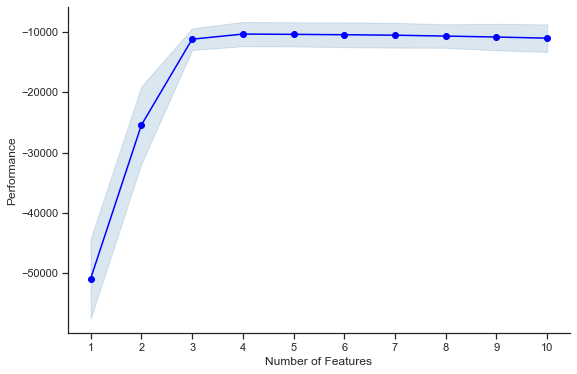

In [136]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

plot_sfs(fwd.get_metric_dict(), kind='std_dev') # The metric is the prediction R-squared by default
sns.despine()
plt.show()

The dimensionality of our problem is small enough that we could actually do an exhaustive search (trying all feature combinations) in this case. However, this method is generally not computationally feasible.

In [138]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector

bss = ExhaustiveFeatureSelector(LinearRegression(), max_features=10, cv=5, scoring='neg_mean_squared_error')
bss.fit(train[predictors], y_train)
bss.best_feature_names_

Features: 1023/1023

('Income', 'Limit', 'Cards', 'Student')

Unfortunately, doing forward selection for kNN would require very advanced coding because of the metric parameters and the choice of `k`. The result is the choice of predictors below with `k=3`. 

In [86]:
subset_knn = [0, 1, 5]  # Income, Limit, Student

### 4.2 Column selector

For practical reasons, it's often useful if we can pass the same `X_train` for all methods, even if they use different features. We use a scikit-learn [pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html?highlight=pipeline#sklearn.pipeline.make_pipeline) to combine a sequence of data processing steps with a learning algorithm.

## Aside - On Pipelines
Pipelins are very much like exercising, they are something that we should all be doing but are too lazy to do it. Now because I'm very lazy, I rarely use pipelines. When I do it is because things became too complicated and I needed to simplify my code. But they are used a lot in the 'industry'.

Suppose you were playing around with some dataset and you finally came up with a good plan of attack. Your game plan was to   
    1. Perform the data transformations (like log transformations) and (or) remove some useless columns
    2. Re-Scale Everything
    3. Fit the model
    
Now you could very easily do this over multiple jupyter notebook cells, using many lines of code. But the 'industry' doesn't like this. It is too much code, and looks very complicated. As such we compress all the notebook cells into a pipeline.

A pipeline is really just a function that does all the data transformation, re-scaling, and fitting the model in ONE line of code. Because all that work is can now be performed in just 1 line of code, rapid prototyping becomes SIGNIFICANLY quicker and easier to read. In comparison, if you keept all the jupyter notebooks, as we have been doing in tutorials, things can get complicated and too hard to read really quickly.

Note that you can just make a function that does all of these steps behind the scenes, but we'll use `make_pipeline` from `sklearn`.

In [30]:
subset_ols

(0, 1, 2, 5)

In [87]:
from sklearn.pipeline import make_pipeline
from mlxtend.feature_selection import ColumnSelector

ols = make_pipeline(ColumnSelector(cols=subset_ols), StandardScaler(), LinearRegression())
ols.fit(train[predictors], y_train)

Pipeline(memory=None,
         steps=[('columnselector',
                 ColumnSelector(cols=[0, 1, 2, 5], drop_axis=False)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

## Aside
You'll see then that we only need 2 lines of code to remove the useless columns, rescale, and fit a linear regression model. If you didn't use this `make_pipeline` it would take you a lot longer. Just look at our previous tutorial notebooks to see.

But really, pipelines are used at the very end of modeling. They are made and used when you finalise the data-transformations, rescaling, and model selection.

For kNN:

In [32]:
subset_knn

[0, 1, 5]

In [139]:
knn = make_pipeline(ColumnSelector(cols=subset_knn),
                    KNeighborsRegressor(n_neighbors=3, metric='mahalanobis', 
                                        metric_params={'V': train.iloc[:, subset_knn].cov()}))
knn.fit(train[predictors], y_train)

Pipeline(memory=None,
         steps=[('columnselector',
                 ColumnSelector(cols=[0, 1, 5], drop_axis=False)),
                ('kneighborsregressor',
                 KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                     metric='mahalanobis',
                                     metric_params={'V':                Income         Limit    Student
Income    1210.189671  6.499956e+04  -0.226186
Limit    64999.556494  5.492703e+06 -30.519713
Student     -0.226186 -3.051971e+01   0.081605},
                                     n_jobs=None, n_neighbors=3, p=2,
                                     weights='uniform'))],
         verbose=False)

## Aside
Note that we choose to use K-NN with 3 neighbours. But one could very easily make a pipline that performs the cross-validation to find the best number of neighbours. In the same sense, you can make a pipline that performs the forward variable selection as well. You can even make a pipeline that does it both. (Come to me in my consultation time if you want to do this)

So pipelines are kind of cool then, using 1-2 lines of code you can have Python:
    1. Transform the data
    2. Perform Variable Selection
    3. Perform cross-validation
    4. Hyper-parameter selection
    5. ...
    6. Build Model
ALL IN 1-2 LINES OF CODE!

But this should be expected. If you told me you went running every day for 1 year, and you tell me that you are fitter than when you first started, that is something I'd expect.

### 4.3 Note

Subset selection is one way to avoid overfitting in the number the features. It has the disadvantage of large computational cost. Regularisation is more common but not always applicable. 

 ## 5. Model stacking
 
From the lecture, the recommended approach for selecting the final model is to fit a model average and perhaps consider a more complex model stack. A model average is a special case of a model stack and always a great place to start because we can interpret the weights.

### 5.1 Standard analysis

We use the [StackingCVRegressor](https://rasbt.github.io/mlxtend/api_subpackages/mlxtend.regressor/#stackingcvregressor) method from the `mlxtend` package. We use a linear regression as the meta-model, which essentially does a model average.

X Train -> Model1 (OLS)
X Train -> Model2 (KNN)
X Train -> Model3 (Tree or Boosted Tree)

(Model1, Model2, Model3) -> Model (Model stack or meta-model)

In [140]:
%%capture 

from mlxtend.regressor import StackingCVRegressor
 
stack = StackingCVRegressor(regressors=[ols,knn], meta_regressor=LinearRegression(), 
                           cv=5, random_state=10, store_train_meta_features=True)
stack.fit(train[predictors], y_train)

Let's check the model weights. They do not sum to one exactly since we do not restrict them, but we can interpret them as saying that meta-model gives about 72% weight to kNN and 28% weight to linear regression.  

## Aside
Notice how we use the `ols` and `knn` pipelines here.

In [141]:
stack.meta_regr_.coef_

array([0.30681792, 0.73316533])

In [142]:
prediction = {}
prediction['Stack'] = stack.predict(train[predictors])

It's also very useful to check how the model stack compares to the individual models. 

In [143]:
from sklearn.model_selection import cross_val_predict

# Initialise table
columns=['CV RMSE', 'CV R-Squared', 'CV MAE']
rows=['Linear Regression', 'kNN', 'Stack']
results = pd.DataFrame(0.0, columns=columns, index=rows)

# Get CV predictions
y_pred = np.zeros((len(y_train), 4)) # initialising a matrix to store the predictions (one extra on purpose)
y_pred[:,:2] = stack.train_meta_features_
y_pred[:, 2] = stack.predict(train[predictors])
# Fill table with the results
for i in range(3):
    results.iloc[i, 0] = np.sqrt(mean_squared_error(y_train, y_pred[:,i]))
    results.iloc[i, 1] = r2_score(y_train, y_pred[:,i])
    results.iloc[i, 2] = mean_absolute_error(y_train, y_pred[:,i])

results.round(2)

,CV RMSE,CV R-Squared,CV MAE
Linear Regression,102.63,0.95,81.67
kNN,76.00,0.97,49.11
Stack,49.31,0.99,37.71


This model stack is very good! 

It's important to understand what's happening statistically. If we compute the correlation between the prediction errors from kNN and linear regression, it's quite weak in this case. In this situation, a model average is very effective for reducing variance, identically to diversification in finance.  

In [38]:
np.corrcoef((y_train.to_numpy().reshape((-1,1))-y_pred[:,:2]).T)

array([[1.        , 0.25482234],
       [0.25482234, 1.        ]])

### 5.2 Adjusted predictions

We can do even better because of the issue that the linear regression model generates negative predictions that are inconsistent with the range of the response.  Ideally, we should use a model that does not do that in the first place. Nevertheless, we should always make the most out of the tools that we currently have. 

The disadvantage is that we have to fit the stack and make adjustments manually if we want to avoid coding that is too advanced. 

In [146]:
# Initialise table
rows=['Linear Regression', 'kNN', 'Stack', 'Stack (adjusted)']
results = pd.DataFrame(0.0, columns=columns, index=rows)

# Adjustment in the linear regression predictions
y_pred[y_pred[:, 0]<0, 0] = 0

# New stack
adjstack = LinearRegression().fit(y_pred[:,:2], y_train)
y_pred[:, 3] = adjstack.predict(y_pred[:,:2])
y_pred[y_pred[:, 3]<0, 3] = 0

# Fill table with the results
for i in range(4):
    results.iloc[i, 0] = np.sqrt(mean_squared_error(y_train, y_pred[:,i]))
    results.iloc[i, 1] = r2_score(y_train, y_pred[:,i])
    results.iloc[i, 2] = mean_absolute_error(y_train, y_pred[:,i])

results.round(2)

,CV RMSE,CV R-Squared,CV MAE
Linear Regression,74.51,0.97,56.54
kNN,76.00,0.97,49.11
Stack,49.31,0.99,37.71
Stack (adjusted),40.54,0.99,27.67


In [144]:
prediction['Linear Regression'] = stack.train_meta_features_[:, 0]
prediction['kNN'] = stack.train_meta_features_[:, 1]

linear_prediction = prediction['Linear Regression']
linear_prediction[linear_prediction < 0] = 0
prediction['Adjusted Linear Regression'] = linear_prediction


adj_inputs = np.c_[prediction['Adjusted Linear Regression'], prediction['kNN']]

adj_stack_model = LinearRegression().fit(adj_inputs, y_train)
adj_stack_pred = adj_stack_model.predict(adj_inputs)
adj_stack_pred[adj_stack_pred < 0] = 0

prediction['Adjusted Stack'] = adj_stack_pred

In [145]:
rows = ['Linear Regression', 'kNN', 'Stack', 'Adjusted Stack']
for r in rows:
    working_prediction = prediction[r]
    
    RMSE = np.sqrt(mean_squared_error(y_train, working_prediction))
    R2 = r2_score(y_train, working_prediction)
    MAE = mean_absolute_error(y_train, working_prediction)
    
    print(f"RMSE = {format(RMSE, '.2f')}; R2 = {format(R2, '.2f')}; MAE = {format(MAE, '.2f')}; Model: {r}")

RMSE = 74.51; R2 = 0.97; MAE = 56.54; Model: Linear Regression
RMSE = 76.00; R2 = 0.97; MAE = 49.11; Model: kNN
RMSE = 49.31; R2 = 0.99; MAE = 37.71; Model: Stack
RMSE = 40.54; R2 = 0.99; MAE = 27.67; Model: Adjusted Stack


## Aside
Notice that we actually adjust the output of the linear regression before we perform the meta-regression.

Now it's the linear regression model that gets more weight. 

In [147]:
adjstack.coef_

array([0.76522707, 0.32917987])

In [148]:
adjstack.coef_/np.sum(adjstack.coef_)

array([0.69921621, 0.30078379])

### 5.3 Final model

Before evaluation, it's essential that we identify what the final model is. Based on the above results, we select the adjusted stack. Even though we will show test results for other models, they are only for benchmarking and discussion.

## 6. Evaluation - Test Set
 
The key point in this tutorial is that everything that we did to arrive at the final model (hyperparameter optimisation, feature selection, and model stacking) was based exclusively on the training data. If model selection works well, the choices that minimise the cross-validation error should approximately be the choices that minimise the risk. 

In evaluation, we estimate the risk of the final model to evaluate whether its generalisation performance achieves the objectives of the machine learning project. In practice, these are business objectives that may require achieving a certain test RMSE or reducing the risk by a certain amount relative a benchmark. 

Since the objective of this project is learning, we take a linear regression based on all the predictors as a benchmark, which was our starting point in this unit.  

The main test results are: 

1. We obtain a large reduction in the risk relative to the benchmark, which achieves the learning goals. For a large final institution, even small improvements in the risk can translate into hundreds of thousands or millions of dollars in business value. 

2. The final model performs very well relative to other models, just as the cross-validation results suggested. 

3.  The test set RMSE is similar to the cross-validation RMSE, which reassures us that the final model did not significantly overfit the training data. 

In [149]:
# Initialise table
columns=['RMSE', 'R-Squared', 'MAE']
rows=['Benchmark', 'Linear Regression', 'kNN', 'Stack', 'Final model (adjusted stack)']
results =pd.DataFrame(0.0, columns=columns, index=rows)

# Benchmark
benchmark = LinearRegression().fit(train[predictors], y_train)

# Methods
methods=[benchmark, ols, knn, stack]

# Compute test predictions
y_pred = np.zeros((len(y_test), 5))
for i, method in enumerate(methods):
    y_pred[:, i] = method.predict(test[predictors])
    
# adjusted method
y_pred[y_pred[:, 1]<0, 1] = 0
y_pred[:, 4] = adjstack.predict(y_pred[:,1:3])
y_pred[y_pred[:, 4]<0, 4] = 0

# Test results
for i in range(5):
    results.iloc[i, 0] = np.sqrt(mean_squared_error(y_test, y_pred[:,i]))
    results.iloc[i, 1] = r2_score(y_test, y_pred[:,i])
    results.iloc[i, 2] = mean_absolute_error(y_test, y_pred[:,i])

results.round(2)

,RMSE,R-Squared,MAE
Benchmark,97.19,0.96,80.03
Linear Regression,78.42,0.97,62.06
kNN,81.15,0.97,49.34
Stack,68.30,0.98,49.95
Final model (adjusted stack),44.33,0.99,31.63


We've come a long way with this data! This application illustrates that there's a lot that we can discover and do even with a small dataset. 

## 7.  Further tasks

If you are looking for a challenge, you can try to modify the code to see if you can improve the models through feature engineering. For example, you can try transforming income and limit and investigate possible interactions. 

Transforming the response can eliminate the issue of negative predictions. 

# Aside - PCA and Dimensionality Reduction

In [45]:
import matplotlib
import matplotlib.pyplot as plt

PCA, or principal component analysis, is relatively simple. It is all encoding. Essentially we want to take a given dataset and represent it into its `principal components`, meaning its main modes.

As a trivial example let us think of colors. Below I have 9 colors and I want you to order them in a way that makes sense. Meaning that I want you to give me a representation such that I can say that `red > purple > blue`.

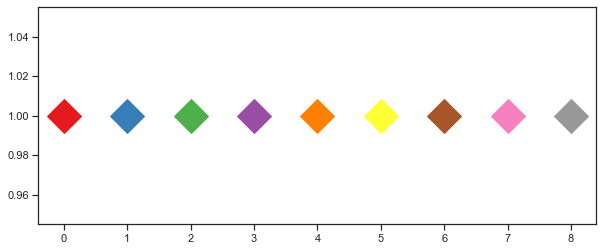

In [46]:
fig = plt.figure(figsize = (10, 4))
color_map = matplotlib.cm.get_cmap('Set1').colors
for i, color in enumerate(color_map):
    plt.plot(i, 1, 'D', color = color, markersize = 24)

An easy way to do this is to simply look at how much red is in a given color. In this case the amount of red is, in order,


In [47]:
[round(c[0], 3) for c in color_map]

[0.894, 0.216, 0.302, 0.596, 1.0, 1.0, 0.651, 0.969, 0.6]

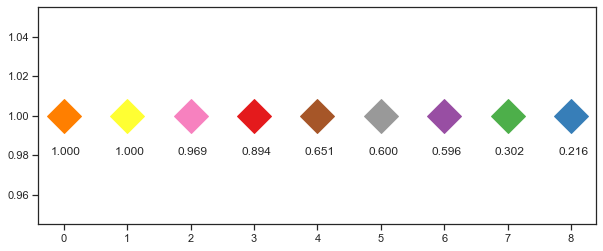

In [48]:
fig = plt.figure(figsize = (10, 4))
color_map = matplotlib.cm.get_cmap('Set1').colors
color_map = sorted(color_map, key = lambda x: x[0], reverse = True)

for i, color in enumerate(color_map):
    plt.plot(i, 1, 'D', color = color, markersize = 24)
    plt.text(i-0.2, 0.98, s = format(color[0], '.3f'), fontsize = 12)

Visually, of course, we see an issue. This encoding seems to suggest that pink (96.9%) is more red that the color red (89.4%) itself! The problem is that we have a really abstract concept, color, but not using enough components to represent it.

Instead we'll use the Red-Green-Blue components.

In [49]:
[[format(c, '.3f') for c in color] for color in color_map]

[['1.000', '0.498', '0.000'],
 ['1.000', '1.000', '0.200'],
 ['0.969', '0.506', '0.749'],
 ['0.894', '0.102', '0.110'],
 ['0.651', '0.337', '0.157'],
 ['0.600', '0.600', '0.600'],
 ['0.596', '0.306', '0.639'],
 ['0.302', '0.686', '0.290'],
 ['0.216', '0.494', '0.722']]

And now everything makes sense. Pink, while having 96.9% red also has 50% Green and 75% Blue. Hence pink looks nothing like the color red.

But this is quite amazing. We now have a way to place color in 3 dimensions, how strange is that?

Anyways, this is what people mean by projecting an object in some high dimensions into lower dimensions. With color, if you want to project them into the red dimension (or component) you look at the color through a red stained glass. The light that passes through it will tell you the red component of the color, the projection on the red axis. You can do the same for the green and blue components

In [50]:
1 = 2

SyntaxError: can't assign to literal (<ipython-input-50-c0ab9e3898ea>, line 1)

In [150]:
%matplotlib notebook

<IPython.core.display.Javascript object>


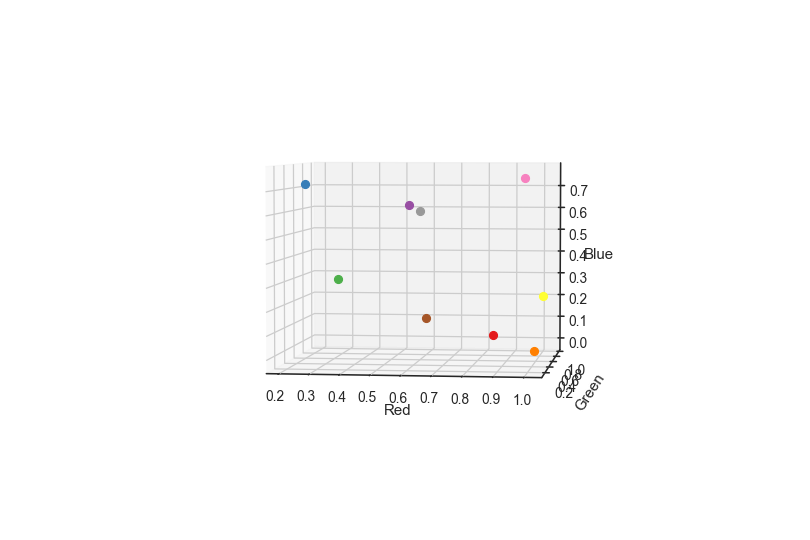

In [151]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for x, y, z in color_map:
    ax.scatter(x, y, z, 'D', color = (x, y, z), s = 40)

ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')

for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

So this is, in essence, what principal component analysis does. Given a dataset it finds the main principal components on which you can project your image on.

One of the problem is that the principal components can be anything. For example, instead of using red-green-blue you can also use yellow-cyan-magenta.

Being a bit more pragmatic about PCA, cars are a very high-dimensional object. But we can break down a car into different main components

    Number of Tires - Number of Doors - Year Built OR
    Number of Cylinders - Type of Engine - Safety Rating etc.
Here we project a car by looking through a lense which makes everything invisible except for the number of tires, another lense that makes everything invisible except for the doors, etc.

Now PCA is a bit more mathematical with how it finds these main components, but the general idea is still the same. That you take some object in some high dimension and break it down into its principal components. Then you can take something like an image and say that is has 

    1.03 of component 1, 0.42 of component 2, 3.41 of component 3, 2.78 of component 4
And so we have broken down something of very high dimensions, like an image, into 4 main components.

As a final example, below I have handwritten numbers (0, 1, 2, ... 9). Now of course one can break it into 10 components, that's easy (I'm actually not sure if this is easy). But an important question is, can you break it down into 3 dimensions?

In [152]:
%matplotlib inline
from keras.datasets import mnist

Using TensorFlow backend.


In [153]:
(X_train, _), _ = mnist.load_data()

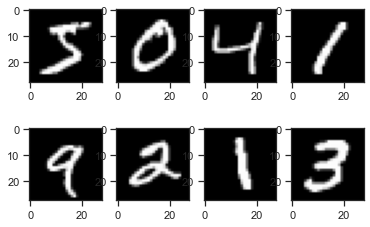

In [154]:
fig = plt.figure()
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(X_train[i], cmap = 'gray')

https://colah.github.io/posts/2014-10-Visualizing-MNIST/

In [ ]:
np.arange(1, 51)

In [ ]:
import random
random.sample(list(np.arange(1, 51)), 20)

0 < parameter < 10

In [ ]:
np.arange(0, 10, 0.1)

In [ ]:
np.random.rand(10)*10 